In [1]:
#%% Import libraries
from __future__ import absolute_import, unicode_literals, print_function
import numpy as np
from pymultinest.solve import solve
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import os
try: os.mkdir('chains')
except OSError: pass
import pickle
import time
#from mpi4py import MPI
plt.style.use('tableau-colorblind10')

import eztao
import celerite
from celerite import GP
from eztao.ts import carma_log_fcoeff_init
from eztao.carma import DRW_term,DHO_term, CARMA_term
from eztao.ts import neg_fcoeff_ll
from oldscripts import helper_functions

In [20]:
#%% Choose and import data
data_file = 'PS1606_WFI.csv'
data = pd.read_csv('./TDCARMA software/data/PS1606_WFI.csv')

#%% Extract data
t = data.iloc[:,0] - min(data.iloc[:,0])
y = data.iloc[:,1]
z = data.iloc[:,3]
yerr = data.iloc[:,2]
zerr = data.iloc[:,4]

#%% Choose (p,q,m) triplet
p = 2
q = 1
m = 3

n_paras = 2 + p + q + (m+1)

<ErrorbarContainer object of 3 artists>

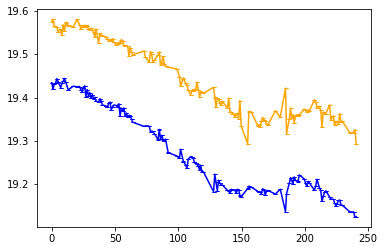

In [21]:
# Plot the data
plt.errorbar(
    t, y, yerr=yerr**2, capsize=2, markersize=3, color = "blue"
)
plt.errorbar(
    t, z, yerr=zerr**2, capsize=2, markersize=3, color = "orange"
)

In [22]:
def fcoeff_ll(log_coeffs, y, gp):
    gp.kernel.set_log_fcoeffs(log_coeffs)
    ll = gp.log_likelihood(y, quiet = True)
    return ll

#%% Initialize GP and log-prob function according to p and q
init_log_fcoeff = carma_log_fcoeff_init(p, q)
init_log_ar, init_log_ma = CARMA_term.fcoeffs2carma_log(init_log_fcoeff, p)
if p == 1:
    gp_kernel = DRW_term(init_log_ar, init_log_ma)
if p == 2:
    gp_kernel = DHO_term(init_log_ar[0], init_log_ar[1], init_log_ma[0], init_log_ma[1])
else:
    gp_kernel = CARMA_term(init_log_ar, init_log_ma)
carma_gp = GP(gp_kernel, mean = np.median(y))

def fcoeff_ll(log_coeffs, y, gp, p):
    if p <= 2:
        gp.set_parameter_vector(log_coeffs)
    else:
        gp.kernel.set_log_fcoeffs(log_coeffs)
    ll = gp.log_likelihood(y, quiet = True)
    return ll

In [23]:
#%% Write prior and likelihood function for normal (unknown mean, known variance)
def myprior(cube):
    params = cube.copy()

    #CARMA log-coefficients (polynomial form)
    params[:p] = [cube[i]* 14 - 7 for i in range(p)]

    params[p: p+q+1] = [cube[i]* 10 - 5 for i in range(p,p+q+1)]

    #Micro-lensing coefficients
    params[p+q+1:p+q+1+m+1] = [cube[i] * 100 - 50 for i in range(p+q+1,p+q+1+m+1)]

    #Delta - this assumes a [0,100] uniform prior
    params[p+q+1+m+1] = cube[p+q+1+m+1] *  (100)

    return params

In [24]:
#%% Time Delay likelihood
def gp_timedelay(params,m,p,q, y, z, yerr, zerr, gp):

    log_carma_coeffs = np.array(params[:p+q+1])
    micro = params[p+q+1:p+q+1+m+1]
    Delta = params[p+q+1+m+1]

    mat = np.empty((len(t),m))
    for i in range(m):
        mat[:,i] = (t - Delta)**(i+1) - np.mean((t - Delta)**(i+1))

    #Perform QR parametrization of covariate matrix
    q_ = np.linalg.qr(mat)[0]

    y_centered = y
    z_centered = z - (micro[0] + np.dot(q_, micro[1:]))

    t_del = t - Delta
    idx = np.argsort(np.concatenate([t_del, t]))
    ordered_times = list(np.sort(np.concatenate([t_del, t])))
    yzcomb_centered = list(np.concatenate([z_centered,y_centered])[idx])
    err_comb = list(np.concatenate([zerr, yerr])[idx])

    yzcomb_centered = yzcomb_centered - np.median(yzcomb_centered)

    ll = -1e30

    try:
        gp.compute(ordered_times, err_comb)
        ll = fcoeff_ll(log_carma_coeffs, yzcomb_centered, gp, p)
    except celerite.solver.LinAlgError as c:
        pass
    
    return ll


def wrapped_gp_loglike(params):
    return gp_timedelay(params,m,p,q, y, z, yerr, zerr, carma_gp)

In [25]:
#%% Function to create array of names for parameters
def parameter_names(m,p,q):
    para_names = []
    for i in range(p+q+1):
        para_names.append("carma_"+str(i+1))
    para_names.append("theta0")
    for j in range(m):
        para_names.append("theta"+str(j+1))
    para_names.append("delta")
    return para_names

In [26]:
#%% Initialize MultiNest
parameters = parameter_names(m,p,q)
n_params = len(parameters)
save_dir = './nest_output/'
prefix = 'gp_'+str(data_file[:-4])+'_c'+str(p)+str(q)+'m'+str(m)+'_'

In [27]:
#%%run MultiNest
start = time.time()

result = solve(LogLikelihood=wrapped_gp_loglike, Prior=myprior, n_live_points = 1000, importance_nested_sampling = False, multimodal = True, 
    use_MPI = True, n_dims=n_params, verbose=True,outputfiles_basename=save_dir+prefix, resume=False)

stop = time.time()

print('Elapsed :', (stop-start)/60, ' min')

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    9
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.999049
Replacements:                               1050
Total Samples:                              1051
Nested Sampling ln(Z):            **************
Acceptance Rate:                        0.994575
Replacements:                               1100
Total Samples:                              1106
Nested Sampling ln(Z):            **************
Acceptance Rate:                        0.992235
Replacements:                               1150
Total Samples:                              1159
Nested Sampling ln(Z):            **************
Acceptance Rate:                        0.985222
Replacements:                              

In [28]:
print()
print('evidence: %(logZ).1f +- %(logZerr).1f' % result)
print()
print('parameter values:')
for name, col in zip(parameters, result['samples'].transpose()):
	print('%15s : %.3f +- %.3f' % (name, col.mean(), col.std()))


evidence: 888.5 +- 0.2

parameter values:
        carma_1 : 6.900 +- 0.095
        carma_2 : -6.897 +- 0.096
        carma_3 : 1.844 +- 0.121
        carma_4 : -1.434 +- 0.134
         theta0 : 0.152 +- 0.001
         theta1 : 0.166 +- 0.015
         theta2 : 0.046 +- 0.016
         theta3 : -0.018 +- 0.017
          delta : 10.431 +- 0.475


TD-CARMA(2,1,3) outputs $\hat{\Delta}_{BA} = 10.431 \pm 0.475$. For comparison, in Millon et al (2020b), the TDCOSMO2 model finds $\hat{\Delta}_{BA} = 10.4 \pm 2.2$ (see: https://obswww.unige.ch/~millon/d3cs/COSMOGRAIL_public/code.php). 
Our paper (https://iopscience.iop.org/article/10.3847/1538-4357/acbea1) studies the frequency properties of the error bars produced by TD-CARMA and show that they are well-calibrated.